In [1]:
import glob
import itertools 
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pybedtools as pb
import pandas as pd
from scipy import stats

import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import subprocess
import time


sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import count_lines as cl
import fet
import plot_params as pp

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import config_readwrite as crw
import chr_functions
import split_filename

# regions config 

In [2]:
NAME = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
configF, configfile_nameF = crw.read_config(NAME)

REGIONS = configF["CIS_TRANS"]["regions"] # intersect w/extended summits
REGIONS_ANNOT = configF["CIS_TRANS"]["regions_annotations"] # intersect w/extended summits
REGIONSxBINS = configF["CIS_TRANS"]["regions_x_bins"] # write

RE = configF["PHYLOP"]["results"]

CONACC_REGIONS = configF["PHYLOP"]["regions"]  # write me.
CONACC_REGIONS_PATH = configF["PHYLOP"]["regions_path"]

# bin config 

In [3]:
NAME = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/fantom/config"
config, configfile_name = crw.read_config(NAME)

CONACC_BINS = config["PHYLOP"]["conacc_tiles"]
ACTIVITY_BINS = config["ACTIVITY_SHAREDACC"]["activity_df"]
BINS = config["ACTIVITY_SHAREDACC"]["bins"]
SELF_BINS = config["SELF"]["data"]

In [4]:
def get_files(path):
    
    ## get all the conacc files
    
    query = os.path.join(path, "chr*/multiz30way_br-hg38_mod-full/*clean.bed")
    
    fs = glob.glob(query)
    print(len(fs))
    
    ## 
    results = {}
    
    for f in fs:
        df = format_df(f)  # format the dataframe
        results[f]=df
    
    # concatenate the results
    df = pd.concat(results.values())
    
    return df

In [ ]:
def format_df(f):
    
    n_lines = cl.count_lines(f)

    if n_lines>0:
        df = pd.read_csv(f, sep = '\t')

        df = df.rename(columns = {"chr": "#chr"}) # do some renaming, correct subtraction mistake
        if "shuf" in f:
            df["start"] = df["start"]-2
        else:
            df["start"] = df["start"]-1

        df["region_id"] = df["#chr"] + ":" + df["start"].map(str) + "-"+df["end"].map(str)

        
        return df

In [56]:
def load_df(f, header, col_names):
    if header is True:
        if "activity_df_bins.tsv" in f:
            df = pd.read_csv(f, sep='\t', dtype={"activity_code":object})
        else:    
            df = pd.read_csv(f, sep='\t')
            df["len"] = df["end"]-df["start"]
        
    elif header is False:
        df = pd.read_csv(f, sep='\t', header = None)

    if len(col_names)>0:
        df.columns = col_names
        
    return df

In [57]:
if os.path.exists(CONACC_REGIONS) is False:
    df = get_files(CONACC_REGIONS_PATH)
    df.to_csv(CONACC_REGIONS, sep = '\t', index = False) 

    print(df.shape)

    df.head()

# make pybedtool objects 

In [8]:
b, r = pb.BedTool(BINS), pb.BedTool(REGIONS)

## write intersection to new file 

In [9]:
r.intersect(b, wao=True, output=REGIONSxBINS)

<BedTool(/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/regions/all_uniq_diffAct_regions2_x_bins.bed)>

# evaluate intersection

In [58]:
names = ["#chr_region", "start_region", "end_region", "region_id", 
         "#chr_bin", "start_bin", "end_bin", "bin_id", "overlap"
        ]
df = pd.read_csv(REGIONSxBINS, sep = '\t', 
                 #nrows = 500, 
                 header = None, names=names)
df

,#chr_region,start_region,end_region,region_id,#chr_bin,start_bin,end_bin,bin_id,overlap
0,chr1,959034,959154,chr1:959034-959154,chr1,958994,959044,bin_1256,10
1,chr1,959034,959154,chr1:959034-959154,chr1,959004,959054,bin_1257,20
2,chr1,959034,959154,chr1:959034-959154,chr1,959014,959064,bin_1258,30
3,chr1,959034,959154,chr1:959034-959154,chr1,959024,959074,bin_1259,40
4,chr1,959034,959154,chr1:959034-959154,chr1,959034,959084,bin_1260,50
...,...,...,...,...,...,...,...,...,...
320524,chr9,137757963,137758213,chr9:137757963-137758213,chr9,137758123,137758173,bin_8085529,50
320525,chr9,137757963,137758213,chr9:137757963-137758213,chr9,137758133,137758183,bin_8085530,50
320526,chr9,137757963,137758213,chr9:137757963-137758213,chr9,137758143,137758193,bin_8085531,50
320527,chr9,137757963,137758213,chr9:137757963-137758213,chr9,137758153,137758203,bin_8085532,50


## Region annotations

In [59]:
regions = load_df(REGIONS_ANNOT, True, [])
regions = regions.rename(columns = {"trans_only":"trans_only_regions", 
                                   "cis_only": "cis_only_regions"})
regions["len"] = regions["end"]-regions["start"]
regions.head()

,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only_regions,cis_only_regions,cis+trans,...,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,len
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,120
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,90
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,260
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,180


## bin activity annotations

In [61]:
activitybins = load_df(ACTIVITY_BINS, True, [])

keep = [
        'bin_id',
        'activity_code',
        'cons_act',
        'Null_0000',
        'cis_only',
        'trans_only',
        'hu_cis_and_trans'
        ]
activitybins = activitybins[keep].drop_duplicates()
activitybins

,bin_id,activity_code,cons_act,Null_0000,cis_only,trans_only,hu_cis_and_trans
0,bin_1013,0000,False,True,False,False,False
1,bin_1014,0000,False,True,False,False,False
2,bin_1015,0000,False,True,False,False,False
3,bin_1016,0000,False,True,False,False,False
4,bin_1017,0000,False,True,False,False,False
...,...,...,...,...,...,...,...
1927895,bin_8085529,1000,False,False,False,False,True
1927896,bin_8085530,1000,False,False,False,False,True
1927897,bin_8085531,1010,False,False,False,True,False
1927898,bin_8085532,1000,False,False,False,False,True


##  phylop region

In [13]:
region_conacc = load_df(CONACC_REGIONS, True, [])
keep = ["phylop","region_id" ]
region_conacc=region_conacc[keep]
region_conacc = region_conacc.rename(columns = {"phylop":"phylop_region"})
region_conacc.head()

,phylop_region,region_id
0,-0.321,chr5:138641966-138642086
1,1.386,chr5:138742482-138742712
2,0.219,chr5:138742722-138742872
3,0.660,chr5:139262615-139262725
4,-0.696,chr5:139273448-139273808


## phylop bin 

In [14]:
bin_conacc = load_df(CONACC_BINS, True, [])
keep = ["bin","br-hg38.mod-full" ]  # keep columns
bin_conacc=bin_conacc[keep].drop_duplicates()  # drop duplicates
bin_conacc = bin_conacc.rename(columns = {"bin":"bin_id", "br-hg38.mod-full":"phylop_bin"})  # rename columns
bin_conacc.head()

,bin_id,phylop_bin
0,bin_100000,-0.239
1,bin_100021,-0.778
2,bin_100022,-0.748
3,bin_100023,-0.620
4,bin_100024,-0.657


## self

In [15]:
self = load_df(SELF_BINS, True, [])
self = self[["bin", "self"]].drop_duplicates()
self = self.rename(columns={"bin":"bin_id"})
self.head()

,bin_id,self
0,bin_1012,True
1,bin_1013,True
2,bin_1014,True
3,bin_1015,True
4,bin_1016,True


## remove self 

In [16]:
bin_conacc = pd.merge(bin_conacc, self, how = "left")
clean_bin_conacc = bin_conacc.loc[bin_conacc["self"]==False]

# merge dataframes

## bin, region phylop scores

In [17]:
scores = pd.merge(df, clean_bin_conacc)

scores = pd.merge(scores, region_conacc)

scores.head()

,#chr_region,start_region,end_region,region_id,#chr_bin,start_bin,end_bin,bin_id,overlap,phylop_bin,self,phylop_region
0,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857358,3857408,bin_25455,10,0.644,False,-0.446
1,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857368,3857418,bin_25456,20,0.586,False,-0.446
2,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857378,3857428,bin_25457,30,0.665,False,-0.446
3,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857388,3857438,bin_25458,40,0.674,False,-0.446
4,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857398,3857448,bin_25459,50,0.625,False,-0.446


##  bin, region annotations

In [62]:
score_annot = pd.merge(scores, activitybins)

score_annot = pd.merge(score_annot, regions)

score_annot.head()

,#chr_region,start_region,end_region,region_id,#chr_bin,start_bin,end_bin,bin_id,overlap,phylop_bin,...,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,len
0,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857358,3857408,bin_25455,10,0.644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
1,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857368,3857418,bin_25456,20,0.586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
2,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857378,3857428,bin_25457,30,0.665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
3,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857388,3857438,bin_25458,40,0.674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
4,chr1,3857398,3857718,chr1:3857398-3857718,chr1,3857398,3857448,bin_25459,50,0.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320


two things are different


    -regions instead of bins
    -calling activity by four-way code v. activity in four distinct experiments. 
    - HH active bins only

In [63]:
region_bin_pairs = [
    #("cis_only_regions", "cis_only"),
    ("HH-active_MM-inactive_cis-only", "cis_only"),
    #("trans_only_regions", "trans_only"),
    ('HH-active_MM-inactive_trans-only', "trans_only"),
    #('cis+trans', "hu_cis_and_trans"),
    ("HH-active_MM-inactive_cis+trans", "hu_cis_and_trans"),
                   ]

In [20]:
pp.fonts()

('sans-serif', 'Arial', 18)

In [22]:
def linear_reg(test):
    y =np.array(test["phylop_region"]).reshape(-1, 1)
    X =np.array(test["phylop_bin"]).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    r, i, c =reg.score(X, y), reg.intercept_, reg.coef_
    print(r,i,c)
    
    return r, i, c

0.29938389000893095 [0.05751239] [[0.70453891]]
0.25504317866006065 [0.10486138] [[0.68571914]]
0.32191226765460557 [0.08679185] [[0.76965962]]


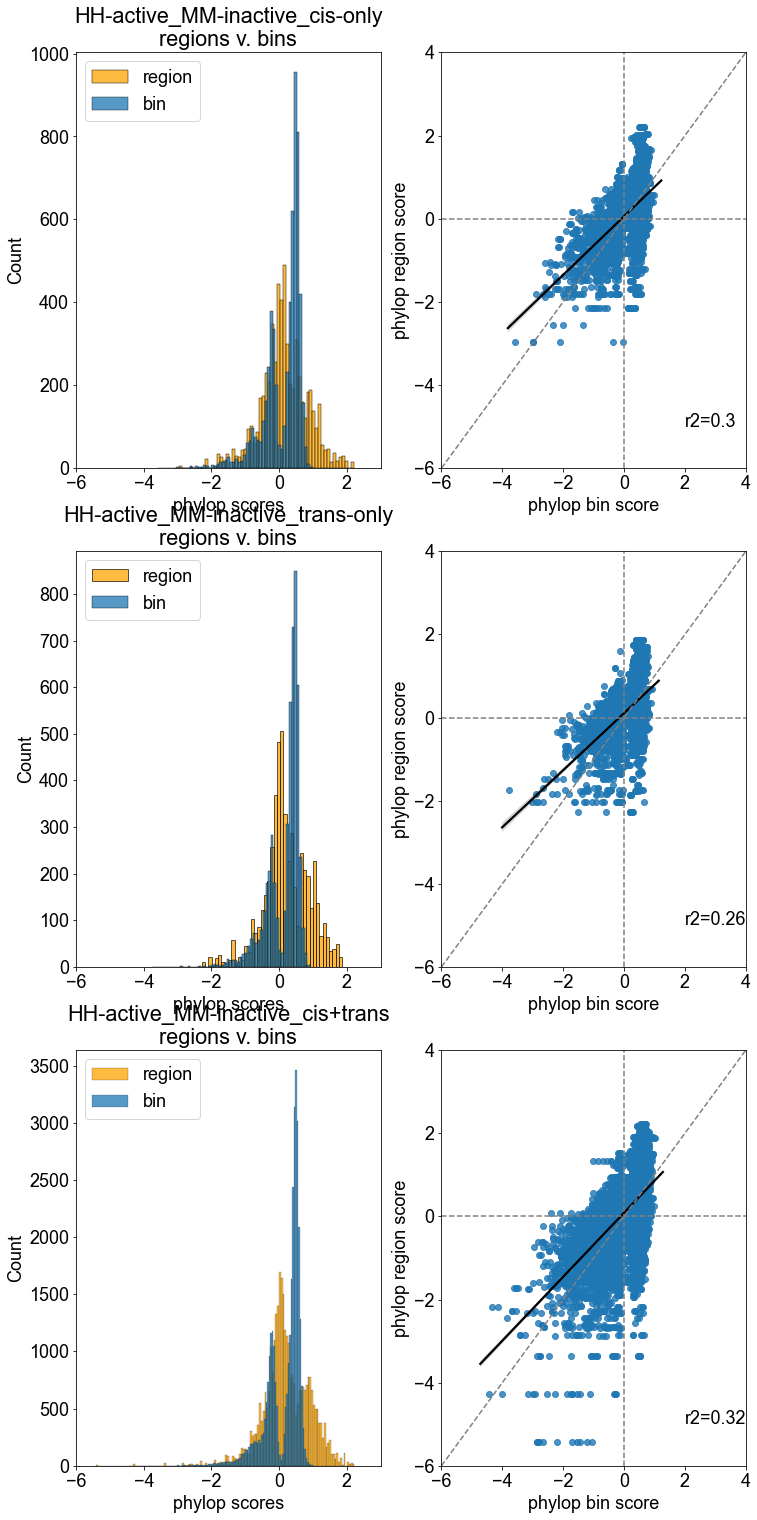

In [68]:
fig, ax_= plt.subplots(ncols = 2, nrows = 3,  figsize=(12, 26), )
#plt.subplots_adjust(left=0.4, right=0.5)

for n, tup in enumerate(region_bin_pairs):

    reg_, bin_ = tup[0], tup[1]
    keep_cols = ['phylop_bin', 'phylop_region', reg_, bin_, "bin_id", "region_id", "self", "len"]
    
    test = score_annot.loc[(score_annot[reg_]==1)
                           &(score_annot[bin_] == True)]
    test = test[keep_cols].drop_duplicates()
                          
    rsquared, intercept, coeff = linear_reg(test)
    
    
    ax1 = ax_[n][0]
    x = "phylop_region"
    data = test
    sns.histplot(x=x, data=data, color = "orange", label = "region", ax=ax1)
    
    x = "phylop_bin"
    sns.histplot(x=x, data=data, label = "bin", ax=ax1)

    ax1.legend()
    
    title = f"{reg_}\nregions v. bins"
    ax1.set(
        xlabel = "phylop scores",
        xlim = (-6,3),
        title = title)
    ax2 = ax_[n][1]
    y = "phylop_region"
    sns.regplot(x=x,y=y,data=data, ax=ax2, truncate=False,
               line_kws = {"color":"k"})
    ax2.axhline(0, ls= "--", color = "grey")
    ax2.axvline(0, ls= "--", color = "grey")
    ax2.set(xlabel = "phylop bin score",
            ylabel = "phylop region score",
            xlim = (-6,4), ylim=(-6,4),
            #title = title
    )
    ax2.plot([-6,4],[-6,4], color = "grey", ls="--")
    ax2.text(2, -5, f"r2={round(rsquared, 2)}")
outf = os.path.join(RE, "region_x_bin_phylop_dist.pdf")
plt.savefig(outf, bbox_inches = "tight")

In [24]:
test

,phylop_bin,phylop_region,HH-active_MM-inactive_cis+trans,hu_cis_and_trans,bin_id,region_id,self
108,0.559,0.836,1.0,True,bin_33576,chr1:6603350-6603450,False
109,0.552,0.836,1.0,True,bin_33577,chr1:6603350-6603450,False
110,0.537,0.836,1.0,True,bin_33578,chr1:6603350-6603450,False
111,0.477,0.836,1.0,True,bin_33579,chr1:6603350-6603450,False
112,0.503,0.836,1.0,True,bin_33580,chr1:6603350-6603450,False
...,...,...,...,...,...,...,...
222138,-0.086,0.164,1.0,True,bin_8071122,chr9:136882362-136882462,False
222139,-0.111,0.164,1.0,True,bin_8071123,chr9:136882362-136882462,False
222140,-0.123,0.164,1.0,True,bin_8071124,chr9:136882362-136882462,False
222142,0.644,0.164,1.0,True,bin_8071126,chr9:136882362-136882462,False


# save regions w/ no self overlap

In [159]:
clean_regions = score_annot[["region_id", "phylop_region"]].drop_duplicates()

OUT_CLEAN_REGIONS = os.path.join(CONACC_REGIONS_PATH, "br-hg38_mod-full_conacc_regions_noself.tsv")
clean_regions.to_csv(OUT_CLEAN_REGIONS, sep = '\t', index = False)

# fit a linear model of distribution stats.  

In [64]:
np.array(test["phylop_region"]).reshape(-1, 1)

array([[0.836],
       [0.836],
       [0.836],
       ...,
       [0.164],
       [0.164],
       [0.164]])

In [69]:
desc = test.groupby(["region_id", "phylop_region", "len"])["phylop_bin"].describe().reset_index()

desc = desc.dropna() # drop na's
desc = desc.loc[desc["phylop_region"]<0]
y = desc['phylop_region']  # phylop-region score is the dependent variable
X = desc[["count", "len"]] # all stat features are independent variables

# fit the regression

In [70]:
reg = LinearRegression().fit(X, y)

## r2 

In [71]:
reg.score(X, y)

0.0011728045616330451

## coeffs - mean has largest coefficient, median has largest negative coefficient 

In [72]:
reg.coef_

array([-0.00065298, -0.00018146])

In [73]:
reg.intercept_

-0.41028352401039797

In [74]:
import statsmodels.api as sm
X = sm.add_constant(X)
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          phylop_region   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7485
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.473
Time:                        11:19:29   Log-Likelihood:                -916.29
No. Observations:                1278   AIC:                             1839.
Df Residuals:                    1275   BIC:                             1854.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4103      0.032    -12.748      0.000      -0.473      -0.347
count         -0.0007      0.004     -0.147      0.883      -0.009       0.008
len           -0.0002      0.000     -0.546      0.585      -0.001       0.000
==============================================================================
Omnibus:                      838.024   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12572.836
Skew:                          -2.834   Prob(JB):                         0.00
Kurtosis:                      17.282   Cond. No.                         408.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
res.params

const   -0.410284
count   -0.000653
len     -0.000181
dtype: float64